# Setup.
---

In [1]:
# Libraries.
import pandas as pd
import numpy as np
import requests
import os
import io
import datetime
import matplotlib.pyplot as plt

# Global Constants.
API_KEY = os.environ["ALPHA_VANTAGE_API_KEY"]
DIR_CACHE = os.path.join(os.getcwd(), 'cache')

# Settings.
plt.rcParams["figure.figsize"] = 20, 8

# Common Function Definitions.
---

In [2]:
def cache_path(file):
    return os.path.join(DIR_CACHE, file)

def cache_exists(file):
    return os.path.exists(cache_path(file))

def read_cache(file, **args):
    return pd.read_csv(cache_path(file), **args)

def write_cache(data, file, **args):
    data.to_csv(cache_path(file), **args)

def api_call(asset, params):
    def param_list():
        pl = ""
        for p in params.keys():
            pl += f"&{p}={params[p]}"
        return pl
    
    return "https://www.alphavantage.co/query?" \
        f"function={asset}" \
        f"{param_list()}" \
        f"&apikey={API_KEY}"
    
def req_to_csv(url):
    r = requests.get(url).content
    return pd.read_csv(io.StringIO(r.decode('utf-8')))

# Deprecated.
#def yyyymmdd_to_yyyymm(d):
#    return d[0:7]

def retrieve_assets(symbols, query_handler):
    assets = {}

    for sym in symbols:
        print(f"Retrieving {sym}...", end='')
        fname = f"{sym}.csv"
        if not cache_exists(fname):
            print('querying...', end='')
            asset = query_handler(sym)
            write_cache(asset, fname, index=False)
        else:
            print('reading...', end='')
            asset = read_cache(fname)
        print('done.')
        assets[sym] = asset
    
    return assets

## Equity Assets.
---

In [3]:
def equity_query_handler(sym):
        call = api_call('TIME_SERIES_DAILY', {
            'symbol': sym,
            'datatype': 'csv',
            'outputsize': 'full',
        })
        
        eq = req_to_csv(call)
        return eq

In [4]:
equity_symbols = ['VTI']
equity = retrieve_assets(equity_symbols, equity_query_handler)

Retrieving VTI...reading...done.


## Digital Currency Assets.
---

In [5]:
def crypto_query_handler(sym):
        call = api_call('DIGITAL_CURRENCY_DAILY', {
            'symbol': sym,
            'datatype': 'csv',
            'market': 'USD',
        })
        
        cr = req_to_csv(call)
        return cr

In [6]:
crypto_symbols = ['BTC', 'ETH']
crypto = retrieve_assets(crypto_symbols, crypto_query_handler)

Retrieving BTC...reading...done.
Retrieving ETH...reading...done.


# Preprocess Assets.
---

In [7]:
def preprocess_equity(dt, k):
    dt['timestamp'] = dt.timestamp.apply(lambda d: datetime.datetime.strptime(d, '%Y-%m-%d'))
    dt = dt.rename(columns={'timestamp': 'date'})
    
    for c in ['open', 'high', 'low', 'close', 'volume']:
        dt = dt.rename(columns={c: f"{k}_{c}"})
    
    return dt

for eq in equity.keys():
    equity[eq] = preprocess_equity(equity[eq], eq)

In [8]:
def preprocess_crypto(dt, k):
    dt['timestamp'] = dt.timestamp.apply(lambda d: datetime.datetime.strptime(d, '%Y-%m-%d'))
    dt = dt.rename(columns={'timestamp': 'date'})
    
    for c in ['open (USD)', 'high (USD)', 'low (USD)', 'close (USD)', 'volume', 'market cap (USD)']:
        dt = dt.rename(columns={c: f"{k}_{c}"})
    
    return dt

for cr in crypto.keys():
    crypto[cr] = preprocess_crypto(crypto[cr], cr)

# Merge Assets.
---

In [9]:
# Instantiate combined table with an index.
dmin, dmax = datetime.date.today(), datetime.date.today()
for eq in equity.keys():
    dmin = min(dmin, equity[eq].date.min())
    dmax = max(dmax, equity[eq].date.max())

# Last couple of days tend to be blank in the API.
dmax = min(dmax, datetime.date(2022, 5, 1))

dt = pd.DataFrame({'date': np.arange(dmin, dmax, dtype='datetime64[D]')})

/tmp/ipykernel_44117/664067231.py:4: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  dmin = min(dmin, equity[eq].date.min())
/tmp/ipykernel_44117/664067231.py:5: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  dmax = max(dmax, equity[eq].date.max())


In [10]:
# Merge equities.
for eq in equity.keys():
    dt = dt.merge(equity[eq][['date', f"{eq}_close"]], on='date', how='left')

In [11]:
# Merge digital currencies.
for cr in crypto.keys():
    dt = dt.merge(crypto[cr][['date', f"{cr}_close (USD)"]], on='date', how='left')

In [12]:
dt.set_index('date', inplace=True)

In [13]:
dt.head()

,VTI_close,BTC_close (USD),ETH_close (USD)
date,,,
2001-05-31,114.8,NaN,NaN
2001-06-01,115.6,NaN,NaN
2001-06-02,NaN,NaN,NaN
2001-06-03,NaN,NaN,NaN
2001-06-04,116.1,NaN,NaN


In [14]:
dt.tail(10)

,VTI_close,BTC_close (USD),ETH_close (USD)
date,,,
2022-04-21,220.22,40480.01,2983.58
2022-04-22,214.22,39709.18,2962.39
2022-04-23,NaN,39441.60,2933.03
2022-04-24,NaN,39450.13,2921.00
2022-04-25,215.39,40426.08,3006.62
2022-04-26,209.25,38112.65,2809.67
2022-04-27,209.66,39235.72,2888.96
2022-04-28,214.77,39742.07,2936.93
2022-04-29,206.88,38596.11,2817.13


# Transform.
---

In [15]:
# Returns.
R = dt / dt.shift() - 1.00

# Forward fill - makes holidays/weekends the prior close for equities, crypto unaffected.
R = R.ffill()

In [16]:
dt.tail()

,VTI_close,BTC_close (USD),ETH_close (USD)
date,,,
2022-04-26,209.25,38112.65,2809.67
2022-04-27,209.66,39235.72,2888.96
2022-04-28,214.77,39742.07,2936.93
2022-04-29,206.88,38596.11,2817.13
2022-04-30,NaN,37630.80,2726.66


In [17]:
R.tail()

,VTI_close,BTC_close (USD),ETH_close (USD)
date,,,
2022-04-26,-0.028506,-0.057226,-0.065505
2022-04-27,0.001959,0.029467,0.028220
2022-04-28,0.024373,0.012905,0.016605
2022-04-29,-0.036737,-0.028835,-0.040791
2022-04-30,-0.036737,-0.025011,-0.032114


# Cross-Sectional Correlation.
---

In [18]:
def weekday_ind(idx, weekdays):
    return [x in weekdays for x in idx]

def weekday_nind(idx, weekdays):
    return [not x for x in weekday_ind(idx, weekdays)]

In [19]:
# Don't include common market close days: 5 = sat, 6 = sun
R.loc[weekday_nind(R.index.dayofweek, [5, 6])].corr()

,VTI_close,BTC_close (USD),ETH_close (USD)
VTI_close,1.000000,0.261869,0.251961
BTC_close (USD),0.261869,1.000000,0.841505
ETH_close (USD),0.251961,0.841505,1.000000


# Leading Correlation.
---

In [20]:
# VTI return from prior day.
R['VTI_Lag1'] = R['VTI_close'].shift()

In [21]:
R.tail(10)

,VTI_close,BTC_close (USD),ETH_close (USD),VTI_Lag1
date,,,,
2022-04-21,-0.016348,-0.021234,-0.030058,-0.001294
2022-04-22,-0.027245,-0.019042,-0.007102,-0.016348
2022-04-23,-0.027245,-0.006738,-0.009911,-0.027245
2022-04-24,-0.027245,0.000216,-0.004102,-0.027245
2022-04-25,-0.027245,0.024739,0.029312,-0.027245
2022-04-26,-0.028506,-0.057226,-0.065505,-0.027245
2022-04-27,0.001959,0.029467,0.028220,-0.028506
2022-04-28,0.024373,0.012905,0.016605,0.001959
2022-04-29,-0.036737,-0.028835,-0.040791,0.024373


In [22]:
# Don't include common days where equity return didn't occur the immediate day before: sun and mon
R.loc[weekday_nind(R.index.dayofweek, [6, 0])].corr()

,VTI_close,BTC_close (USD),ETH_close (USD),VTI_Lag1
VTI_close,1.000000,0.311352,0.302602,0.119671
BTC_close (USD),0.311352,1.000000,0.832605,-0.026216
ETH_close (USD),0.302602,0.832605,1.000000,-0.032457
VTI_Lag1,0.119671,-0.026216,-0.032457,1.000000


# Visualize.
---

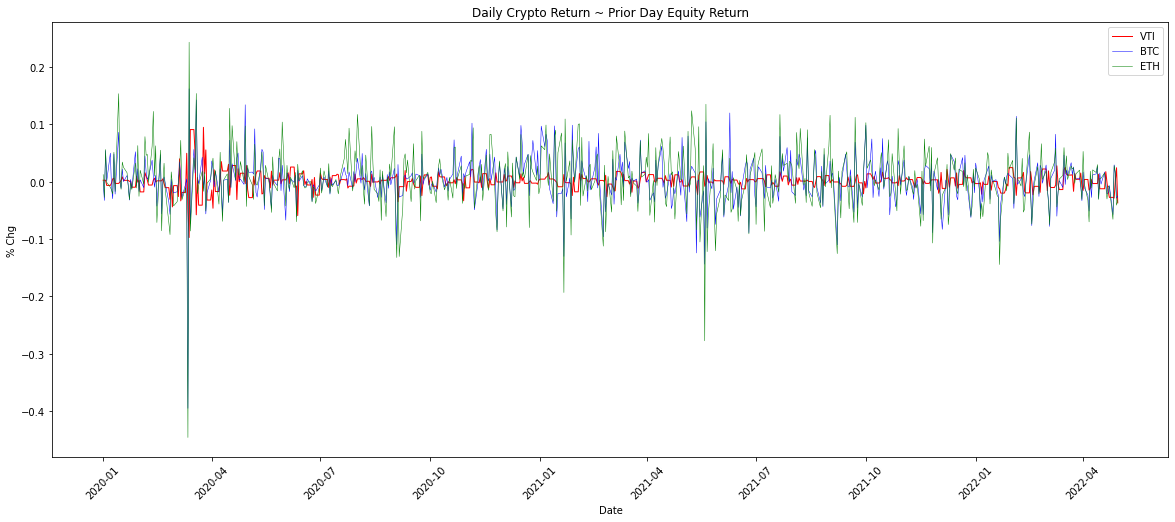

In [23]:
X = R.loc[(weekday_nind(R.index.dayofweek, [6, 0])) & (R.index >= np.datetime64('2020-01-01'))].reset_index()

plt.plot(X.date, X['VTI_Lag1'], color='red', linewidth=1, label='VTI')
plt.plot(X.date, X['BTC_close (USD)'], color='blue', linewidth=0.5, label='BTC')
plt.plot(X.date, X['ETH_close (USD)'], color='green', linewidth=0.5, label='ETH')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('% Chg')
plt.title('Daily Crypto Return ~ Prior Day Equity Return')
plt.legend()
plt.show()

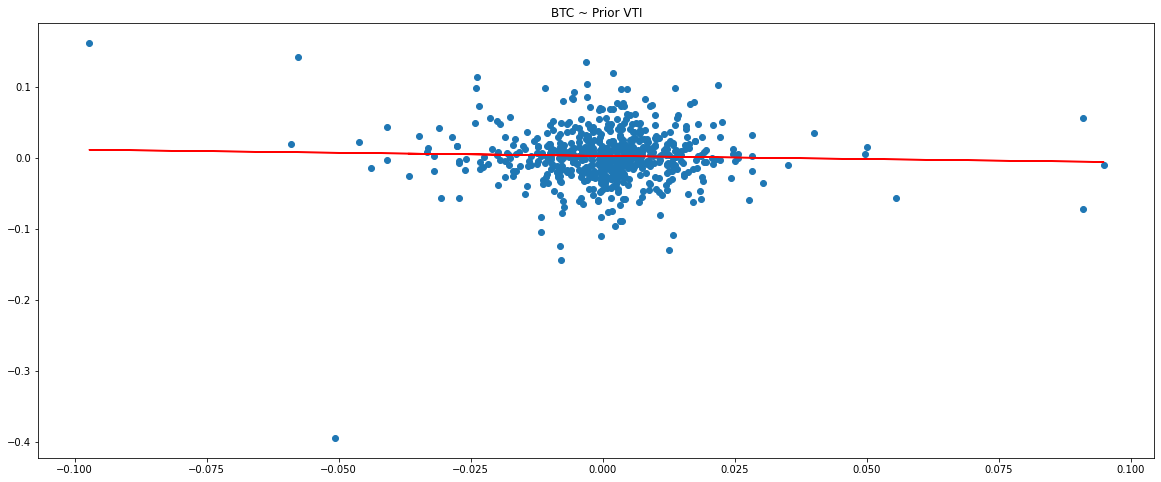

In [24]:
m, b = np.polyfit(X['VTI_Lag1'], X['BTC_close (USD)'], 1)
plt.scatter(X['VTI_Lag1'], X['BTC_close (USD)'])
plt.plot(X['VTI_Lag1'], m*X['VTI_Lag1'] + b, color='red')
plt.title('BTC ~ Prior VTI')
plt.show()

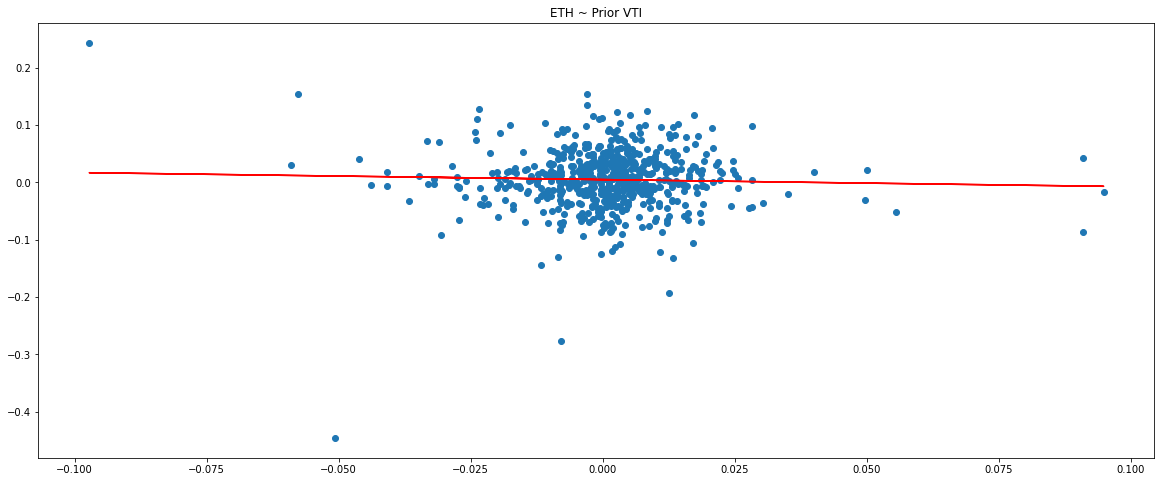

In [25]:
m, b = np.polyfit(X['VTI_Lag1'], X['ETH_close (USD)'], 1)
plt.scatter(X['VTI_Lag1'], X['ETH_close (USD)'])
plt.plot(X['VTI_Lag1'], m*X['VTI_Lag1'] + b, color='red')
plt.title('ETH ~ Prior VTI')
plt.show()